# 1 Load graph data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
import warnings; warnings.filterwarnings('ignore')
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [2]:
data = pd.read_csv("../../Dataset/GLAM-GP/raw/physprop.csv")
# Filter for validated resultsdata_logp = data[data.Status == "Validated"]print("Shape:", data_logp.shape)data_logp.head()

In [3]:
data_logp=data
print("Shape:", data_logp.shape)
data_logp.head()

Shape: (14176, 5)


,Unnamed: 0,SMILES,LogP,LogP rdkit,label
0,1075,Nc1cccc(N)c1,-0.33,0.8510,train
1,7728,CC(C)(SC(=O)N1CCCCC1)c1ccccc1,4.02,4.2608,train
2,8146,CCC(C)c1nnc(N)o1,0.62,1.1653,train
3,11765,CCCCCCCCCC1(c2ccncc2)CCC(=O)NC1=O,4.64,3.8967,train
4,6513,CCNc1nc(NCC)[nH]c(=O)n1,2.29,0.0285,train


In [4]:
molecules = data_logp.SMILES.apply(Chem.MolFromSmiles)
data_logp.loc[:, 'LogP rdkit'] = molecules.apply(Descriptors.MolLogP)
# data_logp = 

In [5]:
data_logp.head()

,Unnamed: 0,SMILES,LogP,LogP rdkit,label
0,1075,Nc1cccc(N)c1,-0.33,0.8510,train
1,7728,CC(C)(SC(=O)N1CCCCC1)c1ccccc1,4.02,4.2608,train
2,8146,CCC(C)c1nnc(N)o1,0.62,1.1653,train
3,11765,CCCCCCCCCC1(c2ccncc2)CCC(=O)NC1=O,4.64,3.8967,train
4,6513,CCNc1nc(NCC)[nH]c(=O)n1,2.29,0.0285,train


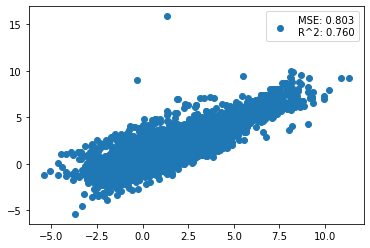

In [6]:

r2 = r2_score(data_logp.LogP, data_logp.loc[:, 'LogP rdkit'])
mse = mean_squared_error(data_logp.LogP, data_logp.loc[:, 'LogP rdkit'])
plt.scatter(data_logp.LogP, data_logp.loc[:, 'LogP rdkit'],
            label = "MSE: {:.3f}\nR^2: {:.3f}".format(mse, r2))
plt.legend()
plt.show()

In [7]:
mse**0.5

0.8959027634491825

# 2. Mutate

In [7]:
from mutation import Configuration, Mutation
from tqdm import tqdm

#from crem.crem import mutate_mol
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import FingerprintSimilarity


mutate_op = Mutation(Configuration(num_mutation_min=1, num_mutation_max=3))

In [8]:
def generate_mutation(smi, real_logp, rdkit_logp, thre=0.2, simi_down=0.8, simi_up=1, func_fp=RDKFingerprint, max_iter=2000):
    for i in range(max_iter):
        try:
            mutation = mutate_op.mutate(smi).smiles
        except:
            continue
        fps = [func_fp(Chem.MolFromSmiles(x)) for x in [smi, mutation]]
        simi = FingerprintSimilarity(fps[0], fps[1])
        mutation_rdkit_logp = Descriptors.MolLogP(Chem.MolFromSmiles(mutation))
        # print(smi, real_logp, rdkit_logp, mutation_rdkit_logp, np.abs(mutation_rdkit_logp-rdkit_logp)/rdkit_logp, thre)
        if simi_down <= simi < simi_up and np.abs(mutation_rdkit_logp-rdkit_logp) < thre:  # abs(x-y) = mae(x, y) = rmse(x, y)
            return mutation, simi, mutation_rdkit_logp
    # print('Not found mutation of {}'.format(smi))
    return None, None, None  # mutation not found

In [9]:
smi, real_logp, rdkit_logp = data_logp['SMILES'][0], data_logp['LogP'][0], data_logp['LogP rdkit'][0], 
generate_mutation(smi, real_logp, rdkit_logp, thre=0.2, simi_down=0.5, simi_up=0.8)

('NC1=CC(N)=CC(F)=C1', 0.5, 0.9901000000000002)

In [10]:
for level in [1,2,3]:
    data_logp['Mutation_level_{}'.format(level)], data_logp['Fingerprint_similrity_level_{}'.format(level)], data_logp['LogP_level_{}'.format(level)]=3*[None]

In [ ]:
# 32 hrs
for i in tqdm(range(len(data_logp))):
    item = data_logp.iloc[i,:]
    smi, real_logp, rdkit_logp = item['SMILES'], item['LogP'], item['LogP rdkit']
    down_ups = {1:[0.8, 1.0], 2:[0.5,0.8], 3:[0.3, 0.5]}
    for level in [1,2,3]:
        down, up = down_ups[level]
        mu, simi, logp = generate_mutation(smi, real_logp, rdkit_logp, thre=0.1, simi_down=down, simi_up=up)
        # print(i, level, mu, simi, logp, rdkit_logp)
        data_logp.iloc[i, level*3-12] = mu     # 3:-3  2:-6   1:-9
        data_logp.iloc[i, level*3-11] = simi   # -2  -5  -8
        data_logp.iloc[i, level*3-10] = logp   # -1  -4  -7
data_logp.to_csv('./physprop_mutate.csv')

  0%|          | 0/14176 [00:00<?, ?it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 12


In [ ]:
# parallel version   will be faster? no
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(16)
import concurrent.futures

def mutations(param):
    i, smi, real_logp, rdkit_logp = param[0], param[1], param[2], param[3]
    down_ups = {1:[0.8, 1.0], 2:[0.5,0.8], 3:[0.3, 0.5]}
    for level in [1,2,3]:
        down, up = down_ups[level]
        mu, simi, logp = generate_mutation(smi, real_logp, rdkit_logp, thre=0.1, simi_down=down, simi_up=up)
        # print(i, level, mu, simi, logp, rdkit_logp)
        print(i, end='\t')
        data_logp.iloc[i, level*3-12] = mu     # 3:-3  2:-6   1:-9
        data_logp.iloc[i, level*3-11] = simi   # -2  -5  -8
        data_logp.iloc[i, level*3-10] = logp   # -1  -4  -7

params = [(i, data_logp['SMILES'][i],data_logp['LogP'][i], data_logp['LogP rdkit'][i]) for i in range(len(data_logp))]
pool.map(mutations, params)
pool.close() 
pool.join() 
data_logp.to_csv('./physprop_mutate.csv')

In [13]:
data_logp

,Unnamed: 0,SMILES,LogP,LogP rdkit,label,Mutation_level_1,Fingerprint_similrity_level_1,LogP_level_1,Mutation_level_2,Fingerprint_similrity_level_2,LogP_level_2,Mutation_level_3,Fingerprint_similrity_level_3,LogP_level_3
0,1075,Nc1cccc(N)c1,-0.33,0.85100,train,None,None,None,None,None,None,NNC1=CC=CC(N)=C1S,0.319527,0.8431
1,7728,CC(C)(SC(=O)N1CCCCC1)c1ccccc1,4.02,4.26080,train,CC(C)(SC(=O)N1CCCSCC1)C1=CC=CC=C1,0.804124,4.2138,CC(C)(SC(=O)N1C=CC(F)CC1)C1=CC=CC=C1,0.657095,4.3324,O=C(SC(F)(Cl)C1=CC=CC=C1)N1CCCCC1,0.461049,4.3443
2,8146,CCC(C)c1nnc(N)o1,0.62,1.16530,train,CC(CCS)C1=NN=C(N)O1,0.885714,1.0752,CSCC(C)C1=NN=C(N)O1,0.561047,1.1183,NC1=NN=C(C(Cl)CCl)O1,0.421053,1.1705
3,11765,CCCCCCCCCC1(c2ccncc2)CCC(=O)NC1=O,4.64,3.89670,train,O=C1CCC(CCCCCCCCBr)(C2=CC=NC=C2)C(=O)N1,0.984351,3.8816,CCCCCCCCCC1(C2=CC=NC=C2)CC(F)NC(=O)NC1=O,0.609221,3.9852,CCC(C)CCCCCCC1(C2=CC=NCOC2)CCC(=O)CNC1=O,0.327902,3.8235
4,6513,CCNc1nc(NCC)[nH]c(=O)n1,2.29,0.02850,train,CCNC1=NC(NCCS)=NC(=O)N1,0.912442,-0.0616,C#CNC1=NC(=O)N(Cl)C(NCC)=N1,0.505102,0.0746,CC(Cl)NNC1=NC(NCF)=NC(=O)N1,0.463889,0.0051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14171,1940,c1cncc(C2CCCCN2)c1,0.97,1.89620,test,SC1CCC(C2=CC=CN=C2)NC1,0.83151,1.8045,C1=CN=CC(C2CCCCON2)=C1,0.545631,1.8278,C1=CN=CC(C2NCCCS2)=C1,0.348276,1.8067
14172,3228,NC(=O)c1cccc(S(N)(=O)=O)c1,-0.84,-0.56710,test,NS(=O)(=O)C1=CC(C(=O)NO)=CC=C1,0.895561,-0.547,NOC(=O)C1=CC=CC(S(N)(=O)=O)=C1,0.612975,-0.6355,NC(F)(OO)C1=CC=CC([SH](N)(=O)NO)=C1,0.393846,-0.6422
14173,2415,Cc1ccc(-c2ccc(C)cc2)cc1,5.09,3.97044,test,None,None,None,CC1=CC=C(C2=CC=C(OS)C=C2)C=C1,0.606218,3.88562,CC1=C(N)C=CC(C2=CC=C(Cl)C=C2)=C1,0.405904,3.89762
14174,11161,N#Cc1ccc(C[Se]CCC(=O)O)cc1,1.37,1.65548,test,None,None,None,None,None,None,None,None,None


# 3. Split

In [25]:
root_path = '../../../../Dataset/AutoGLM-DP/raw/'
data = pd.read_csv(root_path+"physprop_mutate.csv")

In [18]:
# df.sample(frac=1.0): 按100%的比例抽样即达到打乱数据的效果
# np.split   (0, 0.6)  (0.6, 0.8)  (0.8, 1.0) 
train, val, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [19]:
train['label'] = 'train'
val['label'] = 'val'
test['label'] = 'test'

In [21]:
data_split = pd.concat([train, val, test])

In [24]:
data_split.to_csv(root_path+"physprop_mutate.csv")